In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q
!pip install xopt -q
!pip install scipy==1.10.0 -q

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3480, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 3480 (delta 285), reused 264 (delta 261), pack-reused 3183 (from 2)
Receiving objects: 100% (3480/3480), 233.25 MiB | 24.15 MiB/s, done.
Resolving deltas: 100% (2685/2685), done.
Updating files: 100% (144/144), done.
Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 28.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.6/724.6 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.1 M

In [10]:
from google.colab import drive
from google.colab import files
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from scipy.stats import qmc
from split_and_delay import SND
import torch
import gpytorch
import botorch
import warnings
warnings.filterwarnings("ignore")
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.generators.bayesian import ExpectedImprovementGenerator, UpperConfidenceBoundGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt
import math
import pandas as pd

from utilfuncs import *

In [ ]:
#TODOs:
#1. Add utility to get inputs for minimum point
#2. Reverse the objective and constraint behaviors.
#3. Add utility to get raw outputs based on an input dataframe
#4. Repeat chains for set number of runs, save data and plot.

In [5]:
get_snd_outputs(0.5*np.ones((1,8)))

tensor([[0.0284, 1.0240]])

In [16]:
def run_turbo(eval_function=eval_function_intensity,
              objective:str="MAXIMIZE",
              init_samples=64,
              len_chain=150):
  """
  Runs TurBO chain on the eval function with objective,
  with init_samples initial samples followed by len_chain samples.
  Returns the Xopt object.
  """
  low, high = 0.0, 1.0
  n_init = init_samples
  vocs = VOCS(
      variables = {"x1": [low, high],
                  "x2": [low, high],
                  "x3": [low, high],
                  "x4": [low, high],
                  "x5": [low, high],
                  "x6": [low, high],
                  "x7": [low, high],
                  "x8": [low, high]
                  },
      objectives = {"f": objective},
    )
  evaluator = Evaluator(function=eval_function)
  generator = ExpectedImprovementGenerator(
      vocs=vocs, turbo_controller="optimize"
  )
  X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
  # sampler = qmc.LatinHypercube(d=8)
  # xs = sampler.random(n=n_init)
  # init_samples = pd.DataFrame({f'x{i+1}': xs[:,i] for i in range(xs.shape[1])})
  # X.evaluate_data(init_samples)
  X.random_evaluate(n_samples=init_samples)

  for i in range(len_chain):
    if i % 10 == 0:
      print(f"Step: {i+1}")
    X.step()
  return X



In [7]:
def run_bo(eval_function,
           objective:str="MAXIMIZE",
           init_samples=64,
           len_chain=150):
  """
  Runs BO chain on the eval function with objective,
  with init_samples initial samples followed
  by len_chain samples.
  Returns the Xopt object.
  """
  low, high = 0.0, 1.0
  vocs = VOCS(
      variables = {"x1": [low, high],
                  "x2": [low, high],
                  "x3": [low, high],
                  "x4": [low, high],
                  "x5": [low, high],
                  "x6": [low, high],
                  "x7": [low, high],
                  "x8": [low, high]
                  },
      objectives = {"f": objective},
    )
  evaluator = Evaluator(function=eval_function)
  generator = ExpectedImprovementGenerator(vocs=vocs)
  X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
  X.random_evaluate(n_samples=init_samples)
  for i in range(len_chain):
    if i % 10 == 0:
      print(f"Step: {i+1}")
    X.step()
  return X

In [ ]:
X = run_turbo(eval_function_intensity, objective="MAXIMIZE")
plot_results(X, "MAXIMIZE")

Step: 1
Step: 11
Step: 21
Step: 31
Step: 41
Step: 51
Step: 61


In [29]:
X.generator.data.to_csv('data5.csv', index=False)

Step: 1
Step: 11
Step: 21
Step: 31
Step: 41
Step: 51
Step: 61
Step: 71
Step: 81
Step: 91
Step: 101
Step: 111
Step: 121
Step: 131
Step: 141


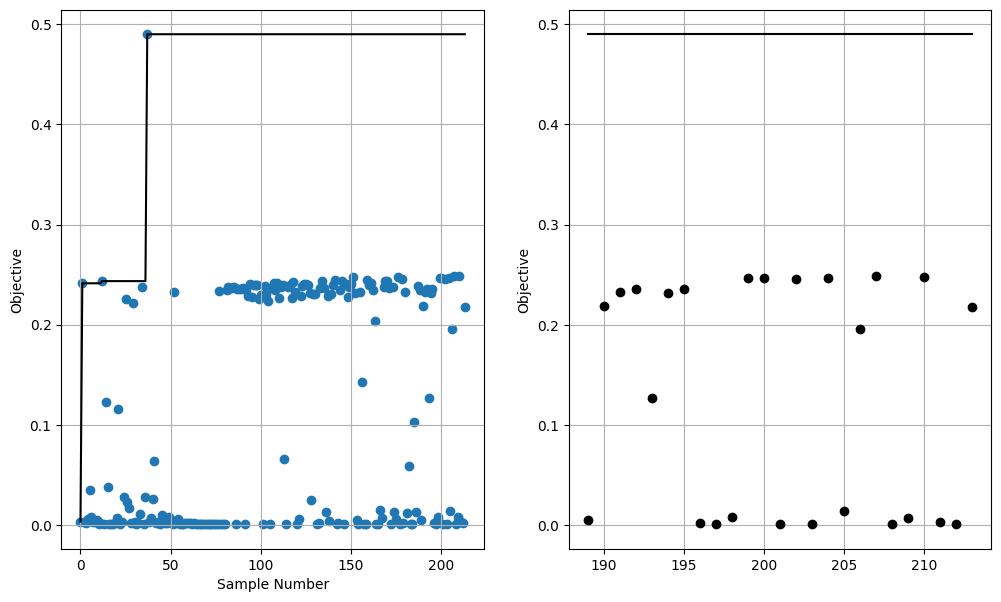

In [20]:
X = run_bo(eval_function_intensity, objective="MAXIMIZE")
plot_results(X, "MAXIMIZE")

In [ ]:
init_samples = pd.DataFrame({f'x{i+1}': X.generator.data[f"x{i+1}"] for i in range(8)})
init_samples

,x1,x2,x3,x4,x5,x6,x7,x8
0,0.475091,0.276110,0.299358,0.087078,0.123683,0.394124,0.416350,0.733819
1,0.537866,0.829535,0.495254,0.900441,0.344809,0.426889,0.310677,0.532300
2,0.723264,0.992088,0.954653,0.736567,0.664077,0.353316,0.198652,0.289429
3,0.360814,0.493507,0.465303,0.432073,0.695778,0.615628,0.101006,0.062506
4,0.569709,0.580932,0.256024,0.361901,0.168695,0.649898,0.988138,0.325822
...,...,...,...,...,...,...,...,...
111,0.541511,0.524983,0.794936,1.000000,0.080395,0.612953,0.211786,0.808487
112,0.538302,0.532785,0.805152,1.000000,0.100977,0.626232,0.204151,0.777234
113,0.537956,0.525361,0.806706,1.000000,0.081448,0.606093,0.209692,0.807436
114,0.538350,0.526591,0.819509,1.000000,0.075043,0.567331,0.194089,0.795037


In [ ]:
X = run_turbo_constrained(eval_function_constrained_intensity, X_init=init_samples, objective="MINIMIZE", len_chain=100)

Step: 1
Step: 11
Step: 21
Step: 31
Step: 41
Step: 51
Step: 61
Step: 71
Step: 81
Step: 91


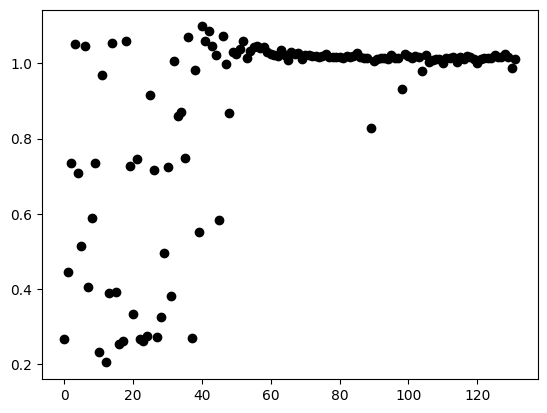

In [ ]:
plt.plot(X.generator.data["c"], 'ok')

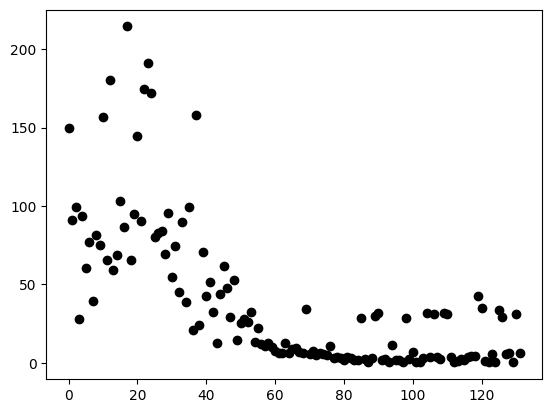

In [ ]:
plt.plot(X.generator.data["f"], 'ok')

In [ ]:
min_idx = np.argmin(X.generator.data["f"])
min_val = X.generator.data["f"][min_idx]
X_min = [X.generator.data["x1"][min_idx],
          X.generator.data["x2"][min_idx],
            X.generator.data["x3"][min_idx],
          X.generator.data["x4"][min_idx],
          X.generator.data["x5"][min_idx],
          X.generator.data["x6"][min_idx],
            X.generator.data["x7"][min_idx],
            X.generator.data["x8"][min_idx]
          ]
print(X_min)
print(min_val)

In [ ]:
chis = [X_min[2], X_min[3], X_min[6], X_min[7]]
print(chis)

In [ ]:
X = run_turbo_intensity(eval_function_intensity, chis=chis)
plot_results(X, "MAXIMIZE")

In [ ]:
min_idx = np.argmax(X.generator.data["f"])
min_val = X.generator.data["f"][min_idx]
X_min = [X.generator.data["x1"][min_idx],
          X.generator.data["x2"][min_idx],
            X.generator.data["x3"][min_idx],
          X.generator.data["x4"][min_idx],
          X.generator.data["x5"][min_idx],
          X.generator.data["x6"][min_idx],
            X.generator.data["x7"][min_idx],
            X.generator.data["x8"][min_idx]
          ]
print(X_min)
print(min_val)

In [ ]:
print(get_snd_outputs(np.array([X_min])))
# print(get_snd_outputs(np.array([[0.75, 0.75, 0.48, 0.04, 0.75, 0.75, 0.99, 0.48]])))

In [ ]:
X = run_turbo(eval_function=eval_function_bpe, objective="MINIMIZE",init_samples=8, len_chain=64)
plot_results(X, objective="MINIMIZE")

In [ ]:
X.generator.turbo_controller.restrict_model_data=False
X.generator.train_model()
X.generator.visualize_model(variable_names=["x3", "x4"])

In [ ]:
init_samples = pd.DataFrame({f'x{i+1}': X.generator.data[f"x{i+1}"] for i in range(8)})
init_samples

In [ ]:
X = run_turbo_constrained(eval_function_constrained, init_samples, "MAXIMIZE", 100)
plot_constrained(X)

In [ ]:
X = run_bo_constrained(eval_function_constrained, init_samples, "MAXIMIZE", 50)
plot_constrained(X)

In [ ]:
X = run_turbo(eval_function_intensity, "MAXIMIZE", 16, 84)
plot_results(X)

In [ ]:
X = run_turbo(eval_function_bpe, "MINIMIZE", 16, 84)
plot_results(X, "MINIMIZE")

In [ ]:
def run_turbo_constrained(eval_function,
                          X_init,
                          objective:str="MAXIMIZE",
                          len_chain=64):
  """
  Runs TurBO chain on the eval function with objective,
  with init_samples initial samples followed by len_chain samples.
  Returns the Xopt object.
  """
  low, high = 0.0, 1.0
  n_init = init_samples
  vocs = VOCS(
      variables = {"x1": [low, high],
                  "x2": [low, high],
                  "x3": [low, high],
                  "x4": [low, high],
                  "x5": [low, high],
                  "x6": [low, high],
                  "x7": [low, high],
                  "x8": [low, high]
                  },
      objectives = {"f": objective},
      constraints={"c": ["LESS_THAN", 10.0]},
    )
  evaluator = Evaluator(function=eval_function)
  generator = ExpectedImprovementGenerator(
      vocs=vocs, turbo_controller="safety"
  )
  X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
  X.evaluate_data(X_init)
  X.generator.train_model()
  X.generator.turbo_controller.update_state(X.generator.data)
  X.generator.turbo_controller.get_trust_region(X.generator.model)

  for i in range(len_chain):
    if i % 10 == 0:
      print(f"Step: {i+1}")
    X.step()
  return X



In [ ]:
def run_bo_constrained(eval_function,
                       X_init,
                       objective:str="MAXIMIZE",
                      len_chain=100):
  """
  Runs BO chain on the eval function with objective,
  with init_samples initial samples followed
  by len_chain samples.
  Returns the Xopt object.
  """
  low, high = 0.0, 1.0
  vocs = VOCS(
      variables = {"x1": [low, high],
                  "x2": [low, high],
                  "x3": [low, high],
                  "x4": [low, high],
                  "x5": [low, high],
                  "x6": [low, high],
                  "x7": [low, high],
                  "x8": [low, high]
                  },
      objectives = {"f": objective},
      constraints={"c": ["LESS_THAN", 10.0]},
    )
  evaluator = Evaluator(function=eval_function)
  generator = ExpectedImprovementGenerator(vocs=vocs)
  X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
  X.evaluate_data(X_init)
  for i in range(len_chain):
    X.step()
  return X

In [ ]:
X = run_turbo_constrained(eval_function_constrained, init_samples, "MAXIMIZE", 100)
plot_results(X)

In [ ]:
def plot_constrained(X, constrain:str="MINIMIZE", objective:str="MAXIMIZE"):

  c = X.generator.data["c"]
  c_mins = np.minimum.accumulate(c)
  f = X.generator.data["f"]
  f_opts = np.maximum.accumulate(f)
  idx = np.arange(len(c))

  print(len(c), len(f), len(idx))

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
  ax0.scatter(idx, c)
  ax0.plot(idx, c_mins,'k')
  ax0.grid()
  ax0.set_xlabel("Sample Number")
  ax0.set_ylabel("Constraint")

  ax1.plot(idx, f_opts,'k')
  ax1.plot(idx, f,'ok')
  ax1.grid()
  ax1.set_ylabel("Intensity");
  plt.show()

In [ ]:
plot_constrained(X)

In [ ]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum
    #my_intensity *= (1.0 + np.random.rand() * 0.01)

    do_centroid = snd.get_IP_r()
    #do_centroid *= (1.0 + np.random.rand() * 0.01)
    # do_centroid_x = snd.get_IP_cx()
    # do_centroid_y = snd.get_IP_cy()


    result.append([do_centroid*1e6, my_intensity/60000])

  return torch.tensor(result, dtype=torch.float)

In [ ]:
def get_snd_outputs_detailed(inputs):
  """
  Takes the X opt features, returns the values of the Beam Position Error and
  Intensity at each sample.
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()

    result.append([do_centroid*1e6, my_intensity])

  return torch.tensor(result, dtype=torch.float)

In [ ]:
def eval_function_intensity(input_dict: dict) -> dict:
  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"], input_dict["x5"], input_dict["x6"], input_dict["x7"], input_dict["x8"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp)
  f = output[0][1].item()
  return {"f": f}

In [ ]:
def eval_function_bpe(input_dict: dict) -> dict:
  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"], input_dict["x5"], input_dict["x6"], input_dict["x7"], input_dict["x8"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp)
  f = output[0][0].item()
  return {"f": f}

In [ ]:
def eval_function(input_dict: dict) -> dict:
  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"], input_dict["x5"], input_dict["x6"], input_dict["x7"], input_dict["x8"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp)
  f = output[0][0].item()
  c = output[0][1].item()
  return {"f": f, "c": c}

In [ ]:
def run_bo(eval_function=eval_function,
           objective:str="MAXIMIZE",
           init_samples=64,
           len_chain=150):
  """
  Runs BO chain on the eval function, with init_samples initial samples followed
  by len_chain samples. c acts as the constraining variable
  Returns the Xopt object.
  """
  low = 0.0
  high = 1.0
  vocs = VOCS(
      variables = {"x1": [low, high],
                  "x2": [low, high],
                  "x3": [low, high],
                  "x4": [low, high],
                  "x5": [low, high],
                  "x6": [low, high],
                  "x7": [low, high],
                  "x8": [low, high]
                  },
      objectives = {"f": objective},
#      constraints={"c": ["GREATER_THAN", 0.8]},
    )
  evaluator = Evaluator(function=eval_function)
  generator = ExpectedImprovementGenerator(vocs=vocs)
  X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
  X.random_evaluate(n_samples=init_samples)
  for i in range(len_chain):
    X.step()
  return X

In [ ]:
def run_bo_intensity(eval_function=eval_function_intensity, init_samples=16, len_chain=50):
  """
  Runs BO chain on the eval function, with init_samples initial samples followed
  by len_chain samples. c acts as the constraining variable
  Returns the Xopt object.
  """
  low = 0.0
  high = 1.0
  vocs = VOCS(
      variables = {"x1": [low, high],
                  "x2": [low, high],
                  "x3": [low, high],
                  "x4": [low, high],
                  "x5": [low, high],
                  "x6": [low, high],
                  "x7": [low, high],
                  "x8": [low, high]
                  },
      objectives = {"f": "MAXIMIZE"},
    )
  evaluator = Evaluator(function=eval_function)
  generator = ExpectedImprovementGenerator(vocs=vocs)
  X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
  X.random_evaluate(n_samples=init_samples)
  for i in range(len_chain):
    X.step()
  return X

In [ ]:
def run_turbo(eval_function=eval_function_intensity,
              objective:str="MAXIMIZE",
              init_samples=32,
              len_chain=50):
  """
  Runs TurBO chain on the eval function, with init_samples initial samples followed
  by len_chain samples.
  Returns the Xopt object.
  """
  low = 0.0
  high = 1.0
  n_init = init_samples
  vocs = VOCS(
      variables = {"x1": [low, high],
                  "x2": [low, high],
                  "x3": [low, high],
                  "x4": [low, high],
                  "x5": [low, high],
                  "x6": [low, high],
                  "x7": [low, high],
                  "x8": [low, high]
                  },
      objectives = {"f": objective},
    )
  evaluator = Evaluator(function=eval_function)
  generator = ExpectedImprovementGenerator(
      vocs=vocs, turbo_controller="optimize"
  )
  X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
  # X.generator.turbo_controller.scale_factor = 1.5
  # X.generator.turbo_controller.success_tolerance = 10
  # X.generator.turbo_controller.failure_tolerance = 10
  # X.generator.turbo_controller.length = 1.0

  sampler = qmc.LatinHypercube(d=8)
  xs = sampler.random(n=n_init)
  init_samples = pd.DataFrame({f'x{i+1}': xs[:,i] for i in range(xs.shape[1])})
  X.evaluate_data(init_samples)

  X.generator.train_model()
  X.generator.turbo_controller.update_state(X.generator.data)
  X.generator.turbo_controller.get_trust_region(X.generator.model)

  for i in range(len_chain):
    if i % 10 == 0:
      print(f"Step: {i+1}")
    model = X.generator.train_model()
    trust_region = X.generator.turbo_controller.get_trust_region(generator.model)\
          .squeeze()
    scale_factor = X.generator.turbo_controller.length
    region_width = trust_region[1] - trust_region[0]
    best_value = X.generator.turbo_controller.best_value

    n_successes = X.generator.turbo_controller.success_counter
    n_failures = X.generator.turbo_controller.failure_counter

    acq = X.generator.get_acquisition(model)

    X.step()

  X.generator.turbo_controller

  return X

In [ ]:
def get_optimum_details(X, plot=True):
  """
  Takes Xopt object, finds the sample with the minimum and prints the settings
  of this sample, the beam position error and the inensity at this setting.
  """
  min_idx = np.argmin(X.generator.data["f"])
  min_val = X.generator.data["f"][min_idx]
  X_min = [X.generator.data["x1"][min_idx],
          X.generator.data["x2"][min_idx],
            X.generator.data["x3"][min_idx],
          X.generator.data["x4"][min_idx],
          X.generator.data["x5"][min_idx],
          X.generator.data["x6"][min_idx],
            X.generator.data["x7"][min_idx],
            X.generator.data["x8"][min_idx]
          ]
  inputs = np.array(X_min)
  inputs = inputs[np.newaxis,:]
  outs = get_snd_outputs_detailed(inputs)
  print("Optimum Inputs: ", X_min)
  print("BPE: ", outs[0][0].item())
  print("Intensity:", outs[0][1].item())

  if plot:
    y1 = X.generator.data["f"]
    y1_mins = np.minimum.accumulate(y1)

    idx = np.arange(len(y1_mins))
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
    ax0.plot(idx, y1_mins,'k')
    ax0.grid()
    ax0.set_xlabel("Sample Number")
    ax0.set_ylabel("Objective")
    ax1.plot(idx[-50:], y1_mins[-50:],'k')
    ax1.grid()
    ax1.set_ylabel("Objective");
    plt.show()


In [ ]:
X = run_turbo(eval_function_bpe, "MINIMIZE", 16, 96)
X.data

In [ ]:
X = run_bo_intensity()
X.data

In [ ]:
X = run_turbo(eval_function_intensity, "MAXIMIZE", init_samples=16, len_chain=80)
X.data

In [ ]:
y1 = X.generator.data["f"]
y1_mins = np.maximum.accumulate(y1)


idx = np.arange(len(y1_mins))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
ax0.scatter(idx, y1)
ax0.plot(idx, y1_mins,'k')
ax0.grid()
ax0.set_xlabel("Sample Number")
ax0.set_ylabel("Objective")

ax1.plot(idx[-25:], y1_mins[-25:],'k')
ax1.plot(idx[-25:], y1[-25:],'ok')
ax1.grid()
ax1.set_ylabel("Objective");

In [ ]:
y1 = X.generator.data["f"]
y1_mins = np.minimum.accumulate(y1)


idx = np.arange(len(y1_mins))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
ax0.scatter(idx, y1)
ax0.plot(idx, y1_mins,'k')
ax0.grid()
ax0.set_xlabel("Sample Number")
ax0.set_ylabel("Objective")

ax1.plot(idx[-25:], y1_mins[-25:],'k')
ax1.plot(idx[-25:], y1[-25:],'ok')
ax1.grid()
ax1.set_ylabel("Objective");

In [ ]:
def plot_optima_from_generator_data(X, plot=True):
  """
  Takes Xopt object, returns and plots the (noise-less) data for
  beam position error and intensity.
  Args:
    X: Xopt object
    plot: boolean to plot or not
  Returns:
    tuple of beam position error sample and intensity sample histories.
  """
  features = ["x1",  "x2", "x3", "x4", "x5",  "x6", "x7", "x8"]
  points = X.generator.data[features].to_numpy()
  outs = get_snd_outputs_detailed(points).numpy()
  bpe_vals,  intensity_vals =   outs[:,0], outs[:,1]
  bpe_optima = np.minimum.accumulate(bpe_vals)
  intensity_optima = np.maximum.accumulate(intensity_vals)

  if plot:
    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
    ax1.plot(bpe_optima, 'k')
    ax1.scatter(np.arange(len(bpe_optima)), bpe_vals)
    ax1.set_xlabel("Sample Number")
    ax1.set_ylabel("BPE (microns)")


    ax2.plot(intensity_optima, 'k')
    ax2.scatter(np.arange(len(intensity_optima)), intensity_vals)
    ax2.set_xlabel("Sample Number")
    ax2.set_ylabel("Intensity")
    plt.show()

  return bpe_vals,  intensity_vals

In [ ]:
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
    constraints={"c": ["LESS_THAN", 0]},
)

In [ ]:
def test_function(input_dict):
    return {"f": np.sin(input_dict["x"]), "c": np.cos(input_dict["x"])}

In [ ]:
evaluator = Evaluator(function=test_function)
generator = ExpectedImprovementGenerator(vocs=vocs)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [ ]:
X.random_evaluate(n_samples=2)

# inspect the gathered data
X.data

In [ ]:
n_steps = 50

# test points for plotting

for i in range(n_steps):

    # do the optimization step
    X.step()

In [ ]:
plt.plot(X.data["f"], "ok")

In [ ]:
plt.plot(X.data["c"], "ok")